# Costa Rican Household Poverty Prediction

### Objective

Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.
The objective is to establish new algorithms which correctly identifies economic conditions of a household so that proper resources are made available to them. Dataset used for this problem contains Costa Rican household characteristics.

### Problem Description

This is a supervised multi-class classification machine learning problem:

1. *Supervised*: provided with the labels for the training data
2. *Multi-class classification*: Labels are discrete values with 4 classes

Dataset can be downloaded from [here](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data). For more details, check the Kaggle description [here](https://www.kaggle.com/c/costa-rican-household-poverty-prediction).

In [34]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt

In [35]:
# To remove the limit on the number of rows displayed by pandas
pd.set_option("display.max_rows", None)

# Read csv files in pandas dataframe
testDf = pd.read_csv('../input/test.csv')
trainDf = pd.read_csv('../input/train.csv')
print("Training dataset basic information")
print("Rows: {}".format(len(trainDf)))
print("Columns: {}".format(len(trainDf.columns)))
trainDf.head()

Training dataset basic information
Rows: 9557
Columns: 143


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [36]:
print("Test dataset basic information")
print("Rows: {}".format(len(testDf)))
print("Columns: {}".format(len(testDf.columns)))
testDf.head()

Test dataset basic information
Rows: 23856
Columns: 142


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [37]:
# Add null Target column to test
testDf['Target'] = np.nan
data = trainDf.append(testDf, ignore_index = True)

### 1. Find and fix missing feature values

In [38]:
# 1. Find missing values in training and test dataset
def findColumnsWithNan(df):
    cols = df.columns[df.isna().any()]
    print("Number of columns with Nan: {}".format(len(cols)))
    print("Column names: {}".format(cols))
    print("-" * 80)
    for col in cols:
        print("Column: [{}] missing {} values.".format(col, len(df[df[col].isna() == True])))

print("Analysis of training dataset...")
findColumnsWithNan(trainDf)

Analysis of training dataset...
Number of columns with Nan: 5
Column names: Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')
--------------------------------------------------------------------------------
Column: [v2a1] missing 6860 values.
Column: [v18q1] missing 7342 values.
Column: [rez_esc] missing 7928 values.
Column: [meaneduc] missing 5 values.
Column: [SQBmeaned] missing 5 values.


In [39]:
print()
print("Analysis of test dataset...")
findColumnsWithNan(testDf)


Analysis of test dataset...
Number of columns with Nan: 6
Column names: Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned', 'Target'], dtype='object')
--------------------------------------------------------------------------------
Column: [v2a1] missing 17403 values.
Column: [v18q1] missing 18126 values.
Column: [rez_esc] missing 19653 values.
Column: [meaneduc] missing 31 values.
Column: [SQBmeaned] missing 31 values.
Column: [Target] missing 23856 values.


#### 1.1. Fix missing values of v2a1 
It means Monthly rent payment. To find what Nan means, v2a1 is compared with 'tipovivi' feature which gives information whether the house is rented/completely paid off etc. <br>

tipovivi1 =1 own and fully paid house <br>
tipovivi2 =1 own,  paying in installments" <br>
tipovivi3 =1 rented <br>
tipovivi4 =1 precarious <br>
tipovivi5 =1 other(assigned,  borrowed)" <br>

'v2a1' is replaced with 0, wherever tipovivi1=1, and all other missing values are left which will be imputed later. This means that if the house is fully owned by household then they don't pay any rent.

In [40]:
data.loc[(data['tipovivi1'] == 1) & (data['v2a1'].isna()), 'v2a1'] = 0
print("Missing values after replacing: {}".format(len(data.loc[data['v2a1'].isna()])))

Missing values after replacing: 3419


#### 1.2. Fix missing values of v18q1
It means number of tablets household owns. After careful analysis of household members, it can concluded that NaN means household does not own a tablet. We replace NaN with 0.

In [41]:
data.loc[data['v18q1'].isna(), 'v18q1'] = 0
print("Missing values after replacing: {}".format(len(data.loc[data['v18q1'].isna()])))

Missing values after replacing: 0


#### 1.3 Fix missing values of rez_esc
It means years behind in school. From the discussions on Kaggle, it can be concluded that this value is defined only for people whose age is between 7 and 19. So the missing values can be updated to 0 using this criteria. Age of an individual is in the column appropriately named 'age'.

In [42]:
data.loc[(data['age'] < 7) & (data['rez_esc'].isna()), 'rez_esc'] = 0
data.loc[(data['age'] > 19) & (data['rez_esc'].isna()), 'rez_esc'] = 0
print("Missing values after replacing: {}".format(len(data.loc[data['rez_esc'].isna()])))

Missing values after replacing: 1161


#### 1.4 Fix missing values of meaneduc
It means average years of education for adults (18+). This implies that if the age of an individual is less than 18 and the value is NaN, then we can replace it with 0. Other NaN are left to be imputed.

In [43]:
data.loc[data['age'] < 19 & data['meaneduc'].isna(), 'meaneduc'] = 0
print("Missing values after replacing: {}".format(len(data.loc[data['meaneduc'].isna()])))

Missing values after replacing: 35


#### 1.5 Fix missing values of SQBmeaned
It means square of the mean years of education of adults (>=18) in the household. It is highly correlated with feature 'age' and there is no real need of it. Hence, this feature is dropped from the dataset.

In [44]:
data.drop('SQBmeaned', inplace=True, axis=1)
print("Total number of columns left: {}".format(len(data.columns)))

Total number of columns left: 142


### 2. Find outliers
Inter-quartile range(IQR) is used to identify outliers in the dataset. IQR is the difference between the 75th and 25th percentile of the data. It is measure of dispersion along the lines of standard deviation. During this analysis, features were found which had incosistent values like integer and boolean string (yes/no) mixed together. These needs to be removed and is the main focus of the next step.

In [45]:
for cols in data.columns[1:]:
    if cols in ['idhogar', 'dependency', 'edjefe', 'edjefa']:
        continue
    percentile75 = np.percentile(data[cols].fillna(0), 75)
    percentile25 = np.percentile(data[cols].fillna(0), 25)
    threshold = (percentile75 - percentile25) * 1.5
    lower, upper = (percentile25 - threshold), (percentile75 + threshold)
    # identify outliers
    outliers = data.loc[(data[cols] < lower) & (data[cols] > upper)]
    if len(outliers) > 0:
        print('Feature: {}. Identified outliers: {}'.format(cols, len(outliers)))

### 3. Find incosistent values
When finding outliers, following three features ('dependency', 'edjefe', 'edjefa') were found to have incosistent values. To take care of this, 'yes' is replaced with 1 and 'no' is replaced with 0. Also, to make sure each value in the feature are of the same data type, features are converted to float.

In [46]:
for col in ['dependency', 'edjefe', 'edjefa']:
    data.loc[data[col] == 'yes', col] = 1.0
    data.loc[data[col] == 'no', col] = 0.0
    data[col] = pd.to_numeric(data[col])

### 4. Remove correlated features
Highly correlated feature pairs are redundant, one of the pairs is selected to be removed.

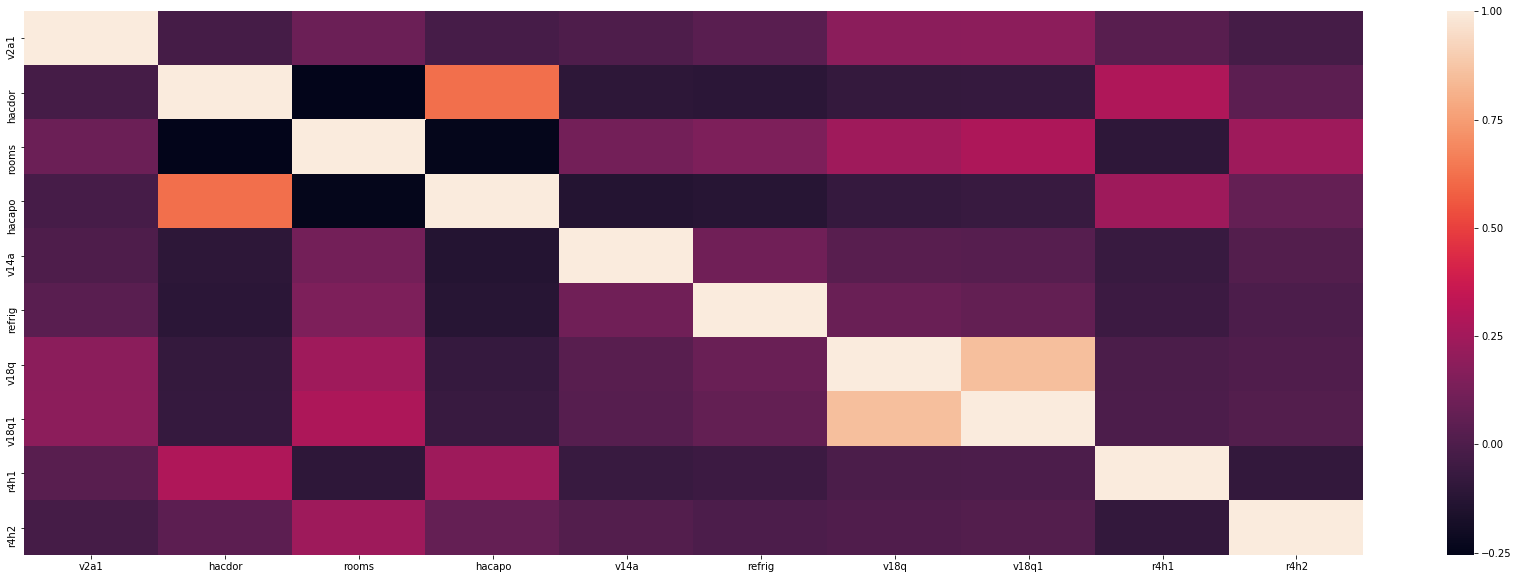

In [47]:
corrMat = data.corr()
plt.figure(figsize=(30, 10))
sns.heatmap(corrMat.iloc[:10, :10])

In [48]:
def featuresToDrop(corrMatrix):
    """
    To remove correlated features, used this gem of a code from here:
    https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features
    """
    # Select upper triangle of correlation matrix
    upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    return [column for column in upper.columns if any(upper[column] > 0.95)]

toDrop = featuresToDrop(corrMat)
data.drop(toDrop, inplace=True, axis=1)
print("Correlated features which are dropped: {}".format(toDrop))

Correlated features which are dropped: ['tamhog', 'hhsize', 'hogar_total', 'SQBage', 'SQBhogar_total', 'agesq']


### 5. Feature engineering
Definition: "Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work."

#### 5.1 Add aggregated features (min, max, std, sum)

In [49]:
features = list(data.drop(columns = ['Id', 'idhogar', 'Target']).columns)
aggDf = data.drop(columns='Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std'])
# Rename the columns
new_col = []
for c in aggDf.columns.levels[0]:
    for stat in aggDf.columns.levels[1]:
        new_col.append('{}-{}'.format(c, stat))
        
aggDf.columns = new_col
toDrop = featuresToDrop(aggDf.corr())
aggDf.drop(toDrop, inplace=True, axis=1)
data = data.merge(aggDf, on='idhogar', how ='left')
print('Training feature shape: ', data.shape)

Training feature shape:  (33413, 525)


#### 5.2 Add features per household

In [50]:
data['phones-per-capita'] = data['qmobilephone'] / data['tamviv']
data['tablets-per-capita'] = data['v18q1'] / data['tamviv']
data['rooms-per-capita'] = data['rooms'] / data['tamviv']
data['rent-per-capita'] = data['v2a1'] / data['tamviv']

### 6. Feature imputing and scaling
Scaling means to transform data in such a way that they fit within a range say 0-100 or 0-1. We will be using min-max scaler to transform the feature to be in the range 0-1.

In [51]:
# Labels for training
trainTarget = np.array(list(data[data['Target'].notnull()]['Target'].astype(np.uint8)))
submission = data.loc[data['Target'].isnull(), 'Id'].to_frame()

# Extract the training data
trainData = data[data['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
testData = data[data['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Impute training and test data
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
trainData = imputer.fit_transform(trainData)
testData = imputer.transform(testData)

# Scale training and test data
scaler = MinMaxScaler()
trainData = scaler.fit_transform(trainData)
testData = scaler.transform(testData)

### 7. Machine Learning model

#### 7.1 Random Forest Classifier

In [52]:
import lightgbm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold

model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')
# 10 fold cross validation
cv_score = cross_val_score(model, trainData, trainTarget, cv=10, scoring=scorer)
print('10 Fold Cross Validation F1 Score = {} with std = {}'.format(round(cv_score.mean(), 4), round(cv_score.std(), 4)))

10 Fold Cross Validation F1 Score = 0.335 with std = 0.0356


#### 7.2 Random Forest Classifier
This extends the random forest classifier used above. It uses tratified K-Folds cross-validation, since this problem has imbalance in the target label.

In [53]:
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True)
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
predicts_result = []
for idx, (train_index, test_index) in enumerate(kf.split(trainData, trainTarget)):
    print("Fold: {}".format(idx + 1))
    X_train, X_val = trainData[train_index], trainData[test_index]
    y_train, y_val = trainTarget[train_index], trainTarget[test_index]
    model.fit(X_train, y_train)
    predicts_result.append(model.predict(testData))
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission.csv', index=False)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5


In [54]:
model = lightgbm.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 14, subsample = 0.96)
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True)

predicts_result = []
for idx, (train_index, test_index) in enumerate(kf.split(trainData, trainTarget)):
    print("Fold: {}".format(idx + 1))
    X_train, X_val = trainData[train_index], trainData[test_index]
    y_train, y_val = trainTarget[train_index], trainTarget[test_index]
    model.fit(X_train, y_train, verbose=100)
    predicts_result.append(model.predict(testData))
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission.csv', index=False)
print("Completed!")

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Completed!


This kernel produces a score of 0.411 (macro f1), which would have given a rank of 214-215 on Kaggle leaderboard for this competition. Kaggle notebook can be found here: https://www.kaggle.com/akverma/costa-rican-poverty-analysis